In [1]:
# Install required libraries
!pip install tensorflow opencv-python Pillow scipy scikit-learn matplotlib seaborn shutil glob

ERROR: Could not find a version that satisfies the requirement shutil (from versions: none)
ERROR: No matching distribution found for shutil


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [3]:
# Paths to original and augmented datasets
original_data_dir = 'C:/Users/HP/Downloads/dataset/Original Dataset/Original Dataset/'
augmented_data_dir = 'C:/Users/HP/Downloads/dataset/Augmented Dataset/Augmented Dataset/'

# Function to get image paths and labels
def get_image_paths_and_labels(data_dir):
    image_paths = glob(os.path.join(data_dir, '*/*.jpg'))
    labels = [os.path.basename(os.path.dirname(path)) for path in image_paths]
    return image_paths, labels


In [4]:
# Get original and augmented data
original_paths, original_labels = get_image_paths_and_labels(original_data_dir)
augmented_paths, augmented_labels = get_image_paths_and_labels(augmented_data_dir)

# Combine original and augmented data
all_paths = original_paths + augmented_paths
all_labels = original_labels + augmented_labels

# Create a DataFrame to facilitate stratified split
data_df = pd.DataFrame({'path': all_paths, 'label': all_labels})


In [5]:
# Stratified split to maintain class distribution
train_df, val_df = train_test_split(data_df, test_size=0.2, stratify=data_df['label'], random_state=42)

# Data augmentation and data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df, x_col='path', y_col='label', target_size=(224, 224), batch_size=16, class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df, x_col='path', y_col='label', target_size=(224, 224), batch_size=16, class_mode='categorical'
)

# Load VGG19 model with pretrained weights
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


Found 17261 validated image filenames belonging to 10 classes.
Found 4316 validated image filenames belonging to 10 classes.


In [6]:
# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

# Get the number of classes
num_classes = len(train_generator.class_indices)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_vgg19_model.keras', monitor='val_loss', save_best_only=True, mode='min')

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluate the model
loss, accuracy = model.evaluate(val_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

# Save the model
model.save('final_vgg19_model.keras')

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 2618s 2s/step - accuracy: 0.2449 - loss: 2.1716 - val_accuracy: 0.3737 - val_loss: 1.7806
Epoch 2/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 2575s 2s/step - accuracy: 0.3295 - loss: 1.8694 - val_accuracy: 0.3821 - val_loss: 1.7263
Epoch 3/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 2583s 2s/step - accuracy: 0.3419 - loss: 1.8123 - val_accuracy: 0.3886 - val_loss: 1.6885
Epoch 4/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 2681s 2s/step - accuracy: 0.3616 - loss: 1.7669 - val_accuracy: 0.4085 - val_loss: 1.6973
Epoch 5/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 2712s 3s/step - accuracy: 0.3687 - loss: 1.7533 - val_accuracy: 0.4196 - val_loss: 1.6192
Epoch 6/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 2698s 3s/step - accuracy: 0.3742 - loss: 1.7283 - val_accuracy: 0.4384 - val_loss: 1.6008
Epoch 7/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 2687s 2s/step - accuracy: 0.3757 - loss: 1.7076 - val_accuracy: 0.4451 - val_loss: 1.5744
Epoch 8/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 2681s 2s/step - accuracy: 0.3962 -

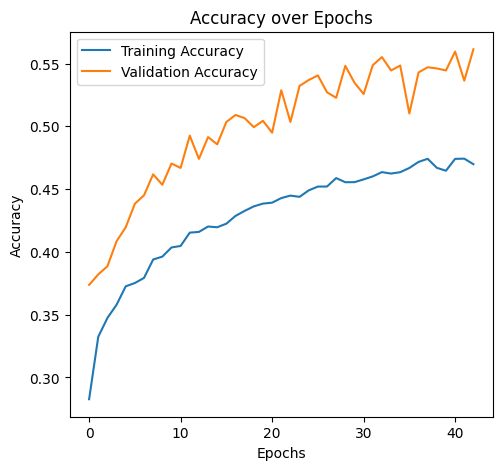

In [7]:
# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy') 
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

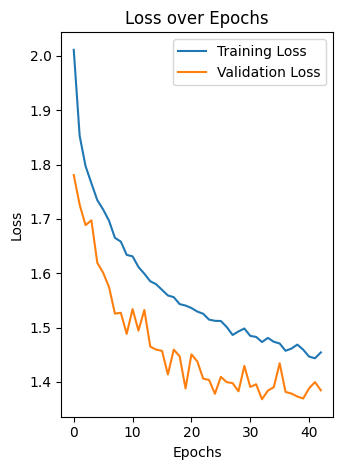

In [8]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()